In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import nest
import numpy as np
import os
import sys 
import re

sys.path.append("..")

from pynestml.frontend.pynestml_frontend import generate_nest_target
from pynestml.codegeneration.nest_code_generator_utils import NESTCodeGeneratorUtils

NEST_SIMULATOR_INSTALL_LOCATION = nest.ll_api.sli_func("statusdict/prefix ::")


              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: 3.5
 Built: Aug 28 2023 10:43:51

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.



In [2]:
neuron_models = [
    "izhikevich.nestml",
    "iaf_psc_exp.nestml",
    "edlif_psc_exp_percent_copy.nestml",
    "edlif_psc_exp_percent.nestml", 
    "edlif_psc_base.nestml", 
    "edlif_psc_nonlineardendrite.nestml",
    "edlif_psc_supply_state.nestml",
    "edlif_psc_supply_inline.nestml",
    "edlif_psc_percent.nestml",
]

neuron_id = 3
#neuron_model = neuron_models[neuron_id]

neuron_model = "edlif_psc_exp_percent.nestml"

In [3]:
def ed_stdp_model_as_str():
    # energy dependent stdp model
    ed_stdp_model = """
synapse ed_stdp:

    state:
        w real = 1

    parameters:
        d ms = 1 ms  @nest::delay
        lambda real = .01
        tau_tr_pre ms = 20 ms
        tau_tr_post ms = 20 ms
        alpha real = 1
        mu_plus real = 0
        mu_minus real = 0
        Wmax real = 100.
        Wmin real = 0.
        eta real = 5  # syanpse sensitivity to energy imbalance

    equations:
        kernel pre_trace_kernel = exp(-t / tau_tr_pre)
        inline pre_trace real = convolve(pre_trace_kernel, pre_spikes)
        kernel post_trace_kernel = exp(-t / tau_tr_post)
        inline post_trace real = convolve(post_trace_kernel, post_spikes)

    input:
        pre_spikes <- spike
        post_spikes <- spike
        post_ATP real <- continuous

    output: 
        spike

    onReceive(post_spikes):
        ATP real = post_ATP/100
        exponent real = eta * (1 - ATP)
        energy_factor_ real = exp(-exponent)
        w_ real = Wmax * (w / Wmax + (energy_factor_ * lambda * (1.0 - (w / Wmax)) ** mu_plus * pre_trace))
        w = min(Wmax, w_)

    onReceive(pre_spikes):
        energy_factor_ real = 1 # post_ATP/100
        w_ real = Wmax * (w / Wmax - (energy_factor_ * alpha * lambda * (w / Wmax) ** mu_minus * post_trace))
        w = max(Wmin, w_)

        deliver_spike(w, d)
"""
    return ed_stdp_model

In [4]:
def generate_code_for(nestml_synapse_model: str, kernel):
    """
    Generate code for a given synapse model, passed as a string,
    in combination with the edlif_psc_XXX_percent model.

    NEST cannot yet reload modules. Workaround using counter to
    generate unique names."""

    global n_modules_generated

    # append digit to the neuron model name and neuron model filename
    with open("models/neurons/" + neuron_model + ".nestml", "r") as nestml_model_file_orig:
        nestml_neuron_model = nestml_model_file_orig.read()
        nestml_neuron_model = re.sub(
            "neuron\ [^:\s]*:",
            "neuron " + neuron_model + str(n_modules_generated) + ":",
            nestml_neuron_model)
        with open("models/neurons/" + neuron_model + str(n_modules_generated) + ".nestml", "w") as nestml_model_file_mod:
            print(nestml_neuron_model, file=nestml_model_file_mod)

    # append digit to the synapse model name and synapse model filename
    nestml_synapse_model_name = re.findall(
        "synapse\ [^:\s]*:",
        nestml_synapse_model)[0][8:-1]
    nestml_synapse_model = re.sub(
        "synapse\ [^:\s]*:",
        "synapse " + nestml_synapse_model_name + str(n_modules_generated) + ":", 
        nestml_synapse_model)
    with open("models/synapses/" + nestml_synapse_model_name + str(n_modules_generated) + ".nestml", "w") as nestml_model_file:
        print(nestml_synapse_model, file=nestml_model_file)

    # generate the code for neuron and synapse (co-generated)
    #module_name = "nestml_" + str(n_modules_generated) + "_module"
    module_name = f"edlif_psc_{kernel}_" + str(n_modules_generated) + "_module"
    input_path = [
        "models/neurons/" + neuron_model + str(n_modules_generated) + ".nestml",
        "models/synapses/" + nestml_synapse_model_name + str(n_modules_generated) + ".nestml"]
    codegen_opts = {
        "nest_path": NEST_SIMULATOR_INSTALL_LOCATION,
        "neuron_parent_class": "StructuralPlasticityNode",
        "neuron_parent_class_include": "structural_plasticity_node.h",
        "neuron_synapse_pairs": [
            {
                "neuron": neuron_model + str(n_modules_generated),
                "synapse": nestml_synapse_model_name + str(n_modules_generated),
                "post_ports": ["post_spikes", ["post_ATP", "ATP"]]
            }
        ]
    }
    generate_nest_target(
        input_path=input_path,
        target_path="/tmp/nestml_module",
        logging_level="DEBUG",
        module_name=module_name,
        suffix="_nestml",
        codegen_opts=codegen_opts)

    # load module into NEST
    nest.ResetKernel()
    nest.Install(module_name)

    mangled_neuron_name = neuron_model + str(n_modules_generated) + \
    "_nestml__with_" + nestml_synapse_model_name + \
    str(n_modules_generated) + "_nestml"
    
    mangled_synapse_name = nestml_synapse_model_name + str(n_modules_generated) \
    + "_nestml__with_" + neuron_model + str(n_modules_generated) + "_nestml"

    n_modules_generated += 1

    print("mangled_neuron_name")
    print(mangled_neuron_name)
    print("mangled_synapse_name")
    print(mangled_synapse_name)
    print(input_path)
    print(codegen_opts)

    return mangled_neuron_name, mangled_synapse_name, module_name

In [5]:
n_modules_generated = 0
#neuron_mod_options = ["edlif_psc_alpha_percent",  # 0
#                    "edlif_psc_exp_percent"]  # 1
neuron_mod_options = ["edlif_psc_exp_percent"]  # 1

#neuron_idx = 0
#neuron_model = neuron_options[neuron_idx]
ed_stdp_model = ed_stdp_model_as_str()
for neuron_model in neuron_mod_options:
    kernel = neuron_model.split('_')[2]
    neuron_model_name, synapse_model_name, module_name = generate_code_for(
                                                            ed_stdp_model,
                                                            kernel
                                                                )
    print(f'neuron model: "{neuron_model_name}"')
    print(f'synapse model: "{synapse_model_name}"')
    print(f'module "{module_name}"generated')


[1,GLOBAL, INFO]: List of files that will be processed:
[2,GLOBAL, INFO]: /home/camilojd/aa_work/CENIA/DishBrain/dishbrain_edlif/edlif/notebooks/models/neurons/edlif_psc_exp_percent0.nestml
[3,GLOBAL, INFO]: /home/camilojd/aa_work/CENIA/DishBrain/dishbrain_edlif/edlif/notebooks/models/synapses/ed_stdp0.nestml
[4,GLOBAL, INFO]: Target platform code will be generated in directory: '/tmp/nestml_module'

              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: 3.5
 Built: Aug 28 2023 10:43:51

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.

[5,GLOBAL, INFO]: The NEST Simulator version was automatically detected as: v3.5
[6,GLOBAL, INFO]: Given template root path is not an absolute path. Creating the absolute path with default templates directory '/home/camilojd/anaconda3/envs/dishbrain/lib/python3.11/site

INFO:Analysing input:
INFO:{
    "dynamics": [
        {
            "expression": "V_abs' = (-V_abs) / tau_m + ((1.0 * I_kernel_ex__X__exc_spikes - 1.0 * I_kernel_in__X__inh_spikes) + I_e + I_stim) / C_m",
            "initial_values": {
                "V_abs": "0"
            }
        },
        {
            "expression": "ATP' = (((ATP_h - ATP) * K_ATP * homeostatic_s_enabled + ATP_basal) - ((ATP_basal + (E_ap_tr * E_ap / tau_ap / o_t) + ((ATP_kernel_ex__X__exc_spikes * E_syn_ex / tau_syn_atp_ex / w_max + ATP_kernel_in__X__inh_spikes * E_syn_in / tau_syn_atp_in / w_min) / o_t / 1.0)))) * o_t * (1 - fix_atp)",
            "initial_values": {
                "ATP": "100"
            }
        },
        {
            "expression": "ATP_kernel_ex__X__exc_spikes = exp(-t / tau_syn_atp_ex)",
            "initial_values": {}
        },
        {
            "expression": "I_kernel_ex__X__exc_spikes = exp(-t / tau_syn_ex)",
            "initial_values": {}
        },
        {
         

ANTLR runtime and generated code versions disagree: 4.13.0!=4.10.1
ANTLR runtime and generated code versions disagree: 4.13.0!=4.10.1
ANTLR runtime and generated code versions disagree: 4.13.0!=4.10.1
ANTLR runtime and generated code versions disagree: 4.13.0!=4.10.1
ANTLR runtime and generated code versions disagree: 4.13.0!=4.10.1
ANTLR runtime and generated code versions disagree: 4.13.0!=4.10.1
ANTLR runtime and generated code versions disagree: 4.13.0!=4.10.1
ANTLR runtime and generated code versions disagree: 4.13.0!=4.10.1
ANTLR runtime and generated code versions disagree: 4.13.0!=4.10.1


DEBUG:Created Shape with symbol V_abs, derivative_factors = [-1/tau_m], inhom_term = I_e/C_m, nonlin_term = (1.0*I_kernel_ex__X__exc_spikes - 1.0*I_kernel_in__X__inh_spikes + I_stim)/C_m
INFO:	Returning shape: Shape "V_abs" of order 1
INFO:Shape V_abs: reconstituting expression -V_abs/tau_m + I_e/C_m + (1.0*I_kernel_ex__X__exc_spikes - 1.0*I_kernel_in__X__inh_spikes + I_stim)/C_m
INFO:
Processing differential-equation form shape ATP with defining expression = "(((ATP_h - ATP) * K_ATP * homeostatic_s_enabled + ATP_basal) - ((ATP_basal + (E_ap_tr * E_ap / tau_ap / o_t) + ((ATP_kernel_ex__X__exc_spikes * E_syn_ex / tau_syn_atp_ex / w_max + ATP_kernel_in__X__inh_spikes * E_syn_in / tau_syn_atp_in / w_min) / o_t / 1.0)))) * o_t * (1 - fix_atp)"
DEBUG:Splitting expression o_t*(1 - fix_atp)*(-E_ap*E_ap_tr/(o_t*tau_ap) + K_ATP*homeostatic_s_enabled*(-ATP + ATP_h) - 1.0*(ATP_kernel_ex__X__exc_spikes*E_syn_ex/(tau_syn_atp_ex*w_max) + ATP_kernel_in__X__inh_spikes*E_syn_in/(tau_syn_atp_in*w_min))/

ANTLR runtime and generated code versions disagree: 4.13.0!=4.10.1
ANTLR runtime and generated code versions disagree: 4.13.0!=4.10.1
ANTLR runtime and generated code versions disagree: 4.13.0!=4.10.1
ANTLR runtime and generated code versions disagree: 4.13.0!=4.10.1
ANTLR runtime and generated code versions disagree: 4.13.0!=4.10.1
ANTLR runtime and generated code versions disagree: 4.13.0!=4.10.1
ANTLR runtime and generated code versions disagree: 4.13.0!=4.10.1
ANTLR runtime and generated code versions disagree: 4.13.0!=4.10.1
ANTLR runtime and generated code versions disagree: 4.13.0!=4.10.1
ANTLR runtime and generated code versions disagree: 4.13.0!=4.10.1
ANTLR runtime and generated code versions disagree: 4.13.0!=4.10.1
ANTLR runtime and generated code versions disagree: 4.13.0!=4.10.1
ANTLR runtime and generated code versions disagree: 4.13.0!=4.10.1
ANTLR runtime and generated code versions disagree: 4.13.0!=4.10.1
ANTLR runtime and generated code versions disagree: 4.13.0!=4.

INFO:Analysing input:
INFO:{
    "dynamics": [
        {
            "expression": "V_abs' = (-V_abs) / tau_m + ((1.0 * I_kernel_ex__X__exc_spikes - 1.0 * I_kernel_in__X__inh_spikes) + I_e + I_stim) / C_m",
            "initial_values": {
                "V_abs": "0"
            }
        },
        {
            "expression": "ATP' = (((ATP_h - ATP) * K_ATP * homeostatic_s_enabled + ATP_basal) - ((ATP_basal + (E_ap_tr * E_ap / tau_ap / o_t) + ((ATP_kernel_ex__X__exc_spikes * E_syn_ex / tau_syn_atp_ex / w_max + ATP_kernel_in__X__inh_spikes * E_syn_in / tau_syn_atp_in / w_min) / o_t / 1.0)))) * o_t * (1 - fix_atp)",
            "initial_values": {
                "ATP": "100"
            }
        },
        {
            "expression": "post_trace_kernel__for_ed_stdp0_nestml__X__post_spikes__for_ed_stdp0_nestml = exp(-t / tau_tr_post__for_ed_stdp0_nestml)",
            "initial_values": {}
        },
        {
            "expression": "ATP_kernel_in__X__inh_spikes = exp(-t / tau_syn_at

ANTLR runtime and generated code versions disagree: 4.13.0!=4.10.1
ANTLR runtime and generated code versions disagree: 4.13.0!=4.10.1
ANTLR runtime and generated code versions disagree: 4.13.0!=4.10.1
ANTLR runtime and generated code versions disagree: 4.13.0!=4.10.1
ANTLR runtime and generated code versions disagree: 4.13.0!=4.10.1
ANTLR runtime and generated code versions disagree: 4.13.0!=4.10.1
ANTLR runtime and generated code versions disagree: 4.13.0!=4.10.1
ANTLR runtime and generated code versions disagree: 4.13.0!=4.10.1
ANTLR runtime and generated code versions disagree: 4.13.0!=4.10.1
ANTLR runtime and generated code versions disagree: 4.13.0!=4.10.1
ANTLR runtime and generated code versions disagree: 4.13.0!=4.10.1


DEBUG:	linear factors: Matrix([[0]])
DEBUG:	inhomogeneous term: 0.0
DEBUG:	nonlinear term: ATP*K_ATP*fix_atp*homeostatic_s_enabled*o_t - ATP*K_ATP*homeostatic_s_enabled*o_t - ATP_h*K_ATP*fix_atp*homeostatic_s_enabled*o_t + ATP_h*K_ATP*homeostatic_s_enabled*o_t + 1.0*ATP_kernel_ex__X__exc_spikes*E_syn_ex*fix_atp/(tau_syn_atp_ex*w_max) - 1.0*ATP_kernel_ex__X__exc_spikes*E_syn_ex/(tau_syn_atp_ex*w_max) + 1.0*ATP_kernel_in__X__inh_spikes*E_syn_in*fix_atp/(tau_syn_atp_in*w_min) - 1.0*ATP_kernel_in__X__inh_spikes*E_syn_in/(tau_syn_atp_in*w_min) + E_ap*E_ap_tr*fix_atp/tau_ap - E_ap*E_ap_tr/tau_ap
DEBUG:Created Shape with symbol ATP, derivative_factors = [0], inhom_term = 0.0, nonlin_term = (1.0*ATP_kernel_ex__X__exc_spikes*E_syn_ex*tau_ap*tau_syn_atp_in*w_min*(fix_atp - 1) + 1.0*ATP_kernel_in__X__inh_spikes*E_syn_in*tau_ap*tau_syn_atp_ex*w_max*(fix_atp - 1) + E_ap*E_ap_tr*tau_syn_atp_ex*tau_syn_atp_in*w_max*w_min*(fix_atp - 1) + K_ATP*homeostatic_s_enabled*o_t*tau_ap*tau_syn_atp_ex*tau_syn_at

ANTLR runtime and generated code versions disagree: 4.13.0!=4.10.1
ANTLR runtime and generated code versions disagree: 4.13.0!=4.10.1
ANTLR runtime and generated code versions disagree: 4.13.0!=4.10.1
ANTLR runtime and generated code versions disagree: 4.13.0!=4.10.1
ANTLR runtime and generated code versions disagree: 4.13.0!=4.10.1
ANTLR runtime and generated code versions disagree: 4.13.0!=4.10.1
ANTLR runtime and generated code versions disagree: 4.13.0!=4.10.1
ANTLR runtime and generated code versions disagree: 4.13.0!=4.10.1
ANTLR runtime and generated code versions disagree: 4.13.0!=4.10.1
ANTLR runtime and generated code versions disagree: 4.13.0!=4.10.1
ANTLR runtime and generated code versions disagree: 4.13.0!=4.10.1
ANTLR runtime and generated code versions disagree: 4.13.0!=4.10.1
ANTLR runtime and generated code versions disagree: 4.13.0!=4.10.1
ANTLR runtime and generated code versions disagree: 4.13.0!=4.10.1
ANTLR runtime and generated code versions disagree: 4.13.0!=4.

INFO:Analysing input:
INFO:{
    "dynamics": [
        {
            "expression": "pre_trace_kernel__X__pre_spikes = exp(-t / tau_tr_pre)",
            "initial_values": {}
        }
    ],
    "options": {
        "output_timestep_symbol": "__h"
    },
    "parameters": {
        "Wmax": "100.0",
        "Wmin": "0.0",
        "alpha": "1",
        "d": "1",
        "eta": "5",
        "lambda": "0.01",
        "mu_minus": "0",
        "mu_plus": "0",
        "tau_tr_post": "20",
        "tau_tr_pre": "20"
    }
}
INFO:Processing global options...
INFO:Processing input shapes...
INFO:
Processing function-of-time shape "pre_trace_kernel__X__pre_spikes" with defining expression = "exp(-t/tau_tr_pre)"
DEBUG:Found t: 0
DEBUG:	Finding ode for order 1...
DEBUG:Created Shape with symbol pre_trace_kernel__X__pre_spikes, derivative_factors = [-1/tau_tr_pre], inhom_term = 0.0, nonlin_term = 0.0
INFO:Shape pre_trace_kernel__X__pre_spikes: reconstituting expression -pre_trace_kernel__X__pre_spik

ANTLR runtime and generated code versions disagree: 4.13.0!=4.10.1
ANTLR runtime and generated code versions disagree: 4.13.0!=4.10.1
ANTLR runtime and generated code versions disagree: 4.13.0!=4.10.1
ANTLR runtime and generated code versions disagree: 4.13.0!=4.10.1
ANTLR runtime and generated code versions disagree: 4.13.0!=4.10.1
ANTLR runtime and generated code versions disagree: 4.13.0!=4.10.1
ANTLR runtime and generated code versions disagree: 4.13.0!=4.10.1
ANTLR runtime and generated code versions disagree: 4.13.0!=4.10.1
[198,ed_stdp0_nestml__with_edlif_psc_exp_percent0_nestml, DEBUG, [2:0;45:0]]: Start building symbol table!
[199,ed_stdp0_nestml__with_edlif_psc_exp_percent0_nestml, WARNING, [8:8;8:28]]: Variable 'd' has the same name as a physical unit!
[200,ed_stdp0_nestml__with_edlif_psc_exp_percent0_nestml, INFO, [5:17;5:17]]: Implicit casting from (compatible) type 'integer' to 'real'.
[201,ed_stdp0_nestml__with_edlif_psc_exp_percent0_nestml, INFO, [12:21;12:21]]: Implici

In [6]:
neuron_model_name, synapse_model_name, module_name

('edlif_psc_exp_percent0_nestml__with_ed_stdp0_nestml',
 'ed_stdp0_nestml__with_edlif_psc_exp_percent0_nestml',
 'edlif_psc_exp_0_module')

In [7]:
"""ed_stdp = True

model_created = False
if not model_created:
    if not ed_stdp:
        generate_nest_target(
            input_path=f"models/neurons/{neuron_model}",
            target_path="/tmp/nestml-component",
            logging_level="INFO",
            codegen_opts={"nest_path": NEST_SIMULATOR_INSTALL_LOCATION})
    else:
        generate_nest_target(
            input_path=[
                f"models/neurons/{neuron_model}",
                f"models/synapses/{nestml_synapse_model}"
            ],
            target_path="/tmp/nestml_module",
            logging_level="DEBUG",
            module_name=module_name,
            suffix="_nestml",
            codegen_opts={
                "nest_path": NEST_SIMULATOR_INSTALL_LOCATION,
                "neuron_parent_class": "StructuralPlasticityNode",
                "neuron_parent_class_include": "structural_plasticity_node.h",
                "neuron_synapse_pairs": [{
                    "neuron": neuron_model,
                    "synapse": nestml_synapse_model,
                    "post_ports": [
                        "post_spikes", 
                        ["post_ATP", "ATP"]
                    ]
                }]
            }
        )"""

'ed_stdp = True\n\nmodel_created = False\nif not model_created:\n    if not ed_stdp:\n        generate_nest_target(\n            input_path=f"models/neurons/{neuron_model}",\n            target_path="/tmp/nestml-component",\n            logging_level="INFO",\n            codegen_opts={"nest_path": NEST_SIMULATOR_INSTALL_LOCATION})\n    else:\n        generate_nest_target(\n            input_path=[\n                f"models/neurons/{neuron_model}",\n                f"models/synapses/{nestml_synapse_model}"\n            ],\n            target_path="/tmp/nestml_module",\n            logging_level="DEBUG",\n            module_name=module_name,\n            suffix="_nestml",\n            codegen_opts={\n                "nest_path": NEST_SIMULATOR_INSTALL_LOCATION,\n                "neuron_parent_class": "StructuralPlasticityNode",\n                "neuron_parent_class_include": "structural_plasticity_node.h",\n                "neuron_synapse_pairs": [{\n                    "neuron": neuron_

In [8]:
"""nest.Install("nestmlmodule")
"""

'nest.Install("nestmlmodule")\n'

In [9]:
"""neuron_model_name = neuron_model.split(".")[0]
print(f"Using neuron model: {neuron_model_name}")"""

'neuron_model_name = neuron_model.split(".")[0]\nprint(f"Using neuron model: {neuron_model_name}")'

# One neuron example

In [10]:
neuron = nest.Create(neuron_model_name)

# current generator
gen = "ac" # dc o ac
print(f"Using {gen} current generator")


voltmeter = nest.Create("voltmeter")

voltmeter.set({"record_from": ["V_m", "ATP", "ATP_c", "ATP_s", "E_ap_tr", "E_ap_c"]}) #, "E_ap_der", "E_ap_tr2"]})
nest.Connect(voltmeter, neuron)

if gen == "dc":
    cgs = nest.Create('dc_generator')
    cgs.set({"amplitude": 1.86})
elif gen == "ac":
    cgs = nest.Create('ac_generator')
    cgs.set({"amplitude": 300.2})
    cgs.set({"offset": 700.2})
    cgs.set({"frequency": 4})
    
nest.Connect(cgs, neuron)
#neuron.I_e = 2000

sr = nest.Create("spike_recorder")
nest.Connect(neuron, sr)

nest.Simulate(500.)

# precision
#error = nest.GetStatus(neuron, "gsl_error_tol")
#print(f"absolute error of integration: {error}")

spike_times = nest.GetStatus(sr, keys='events')[0]['times']

Using ac current generator

May 09 22:39:15 NodeManager::prepare_nodes [Info]: 
    Preparing 4 nodes for simulation.

May 09 22:39:15 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 4
    Simulation time (ms): 500
    Number of OpenMP threads: 1
    Not using MPI

May 09 22:39:15 SimulationManager::run [Info]: 
    Simulation finished.


DEBUG:findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
DEBUG:findfont: score(FontEntry(fname='/home/camilojd/anaconda3/envs/dishbrain/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/STIXGeneral.ttf', name='STIXGeneral', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:findfont: score(FontEntry(fname='/home/camilojd/anaconda3/envs/dishbrain/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/cmex10.ttf', name='cmex10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:findfont: score(FontEntry(fname='/home/camilojd/anaconda3/envs/dishbrain/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/STIXNonUniBolIta.ttf', name='STIXNonUnicode', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
DEBUG:findfont: score(FontEntry(fname='/home/camilojd/anaconda3/envs/dishbrain/lib/python3.11/site

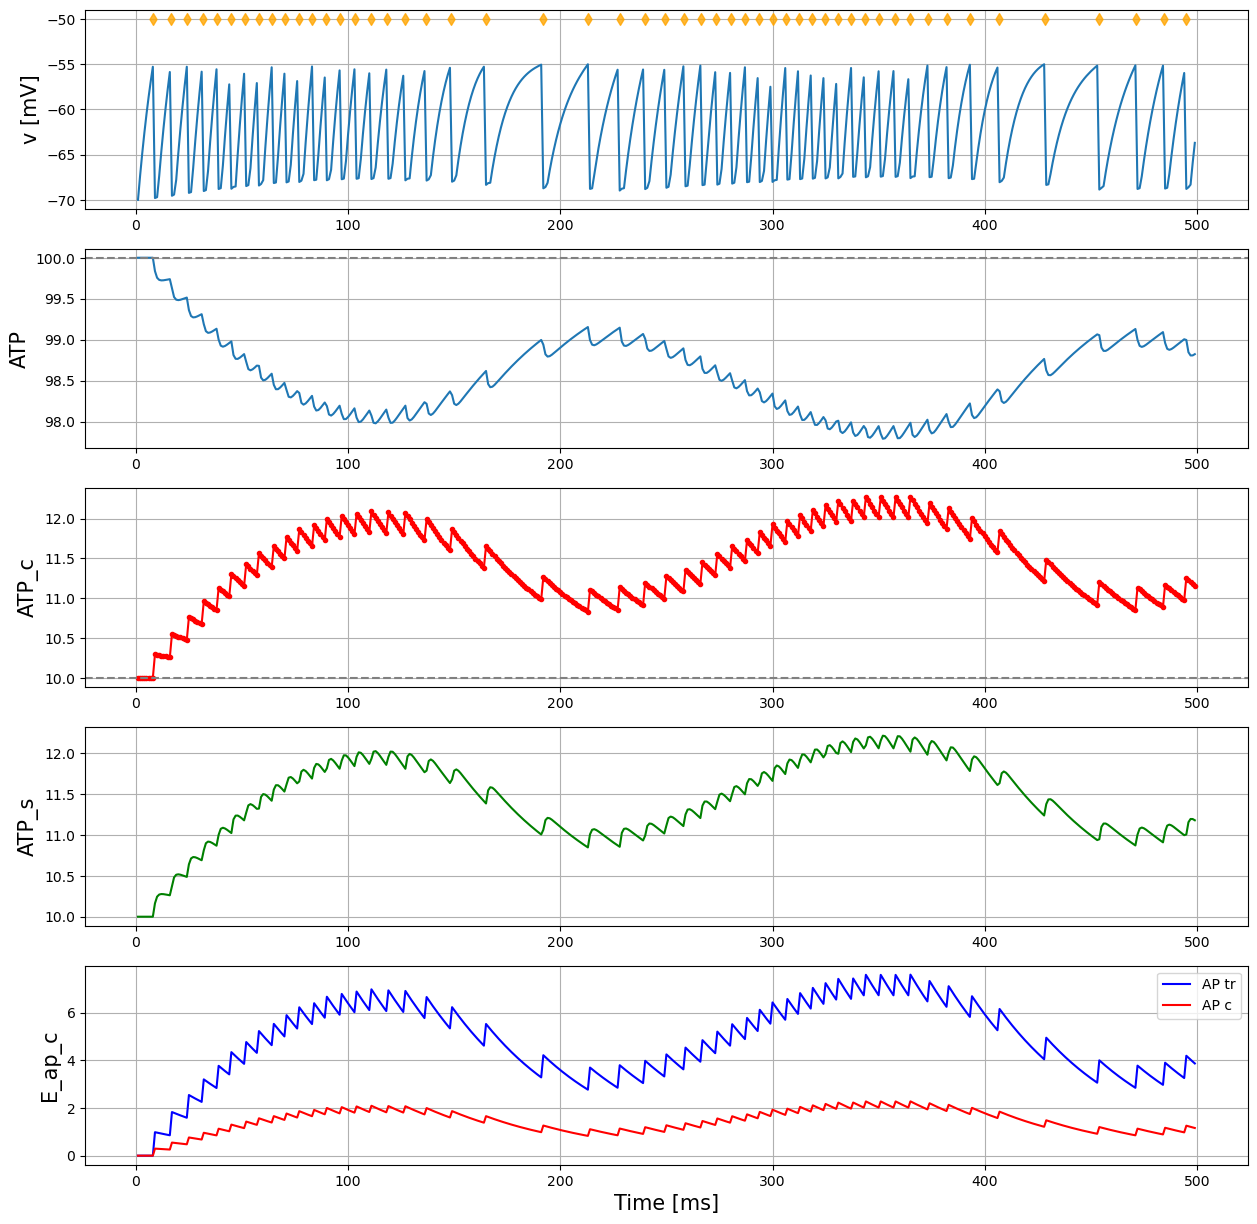

In [11]:
fontsize = 15
fig, ax = plt.subplots(nrows=5, figsize=(15,15))
ax[0].plot(voltmeter.get("events")["times"], voltmeter.get("events")["V_m"])
ax[1].plot(voltmeter.get("events")["times"], voltmeter.get("events")["ATP"])
ax[1].axhline(y=neuron.get("ATP_h"), c="gray", ls="--")
ax[2].plot(voltmeter.get("events")["times"], voltmeter.get("events")["ATP_c"], c="r", marker ='.')
ax[2].axhline(y=neuron.get("ATP_basal"), c="gray", ls="--")
ax[3].plot(voltmeter.get("events")["times"], voltmeter.get("events")["ATP_s"], c="g")
ax[4].plot(voltmeter.get("events")["times"], voltmeter.get("events")["E_ap_tr"], c="b", label="AP tr")
ax[4].plot(voltmeter.get("events")["times"], voltmeter.get("events")["E_ap_c"], c="r", label="AP c")
#ax[5].plot(voltmeter.get("events")["times"], voltmeter.get("events")["E_ap_tr2"], c="b")
#ax[5].plot(voltmeter.get("events")["times"], voltmeter.get("events")["E_ap_der"], c="r")
ax[0].scatter(spike_times, -50 * np.ones_like(spike_times), marker="d", c="orange", alpha=.8, zorder=99)
for _ax in ax:
    _ax.grid(True)
ax[0].set_ylabel("v [mV]", fontsize=fontsize)
ax[1].set_ylabel("ATP", fontsize=fontsize)
ax[2].set_ylabel("ATP_c", fontsize=fontsize)
ax[3].set_ylabel("ATP_s", fontsize=fontsize)
ax[4].set_ylabel("E_ap_tr", fontsize=fontsize)
ax[4].set_ylabel("E_ap_c", fontsize=fontsize)
ax[-1].set_xlabel("Time [ms]", fontsize=fontsize)
ax[4].legend()
fig.show()

# Two neuron example

resolution time: 0.1
Using neuron model: edlif_psc_exp_percent0_nestml__with_ed_stdp0_nestml
Using pg current generator

May 09 22:39:15 edlif_psc_exp_percent0_nestml [Warning]: 
    Simulation resolution has changed. Internal state and parameters of the 
    model have been reset!

May 09 22:39:15 edlif_psc_exp_percent0_nestml__with_ed_stdp0_nestml [Warning]: 
    Simulation resolution has changed. Internal state and parameters of the 
    model have been reset!
idx: 0
idx: 1


/tmp/ipykernel_1815946/1093894017.py:132: UserWarning:FigureCanvasAgg is non-interactive, and thus cannot be shown


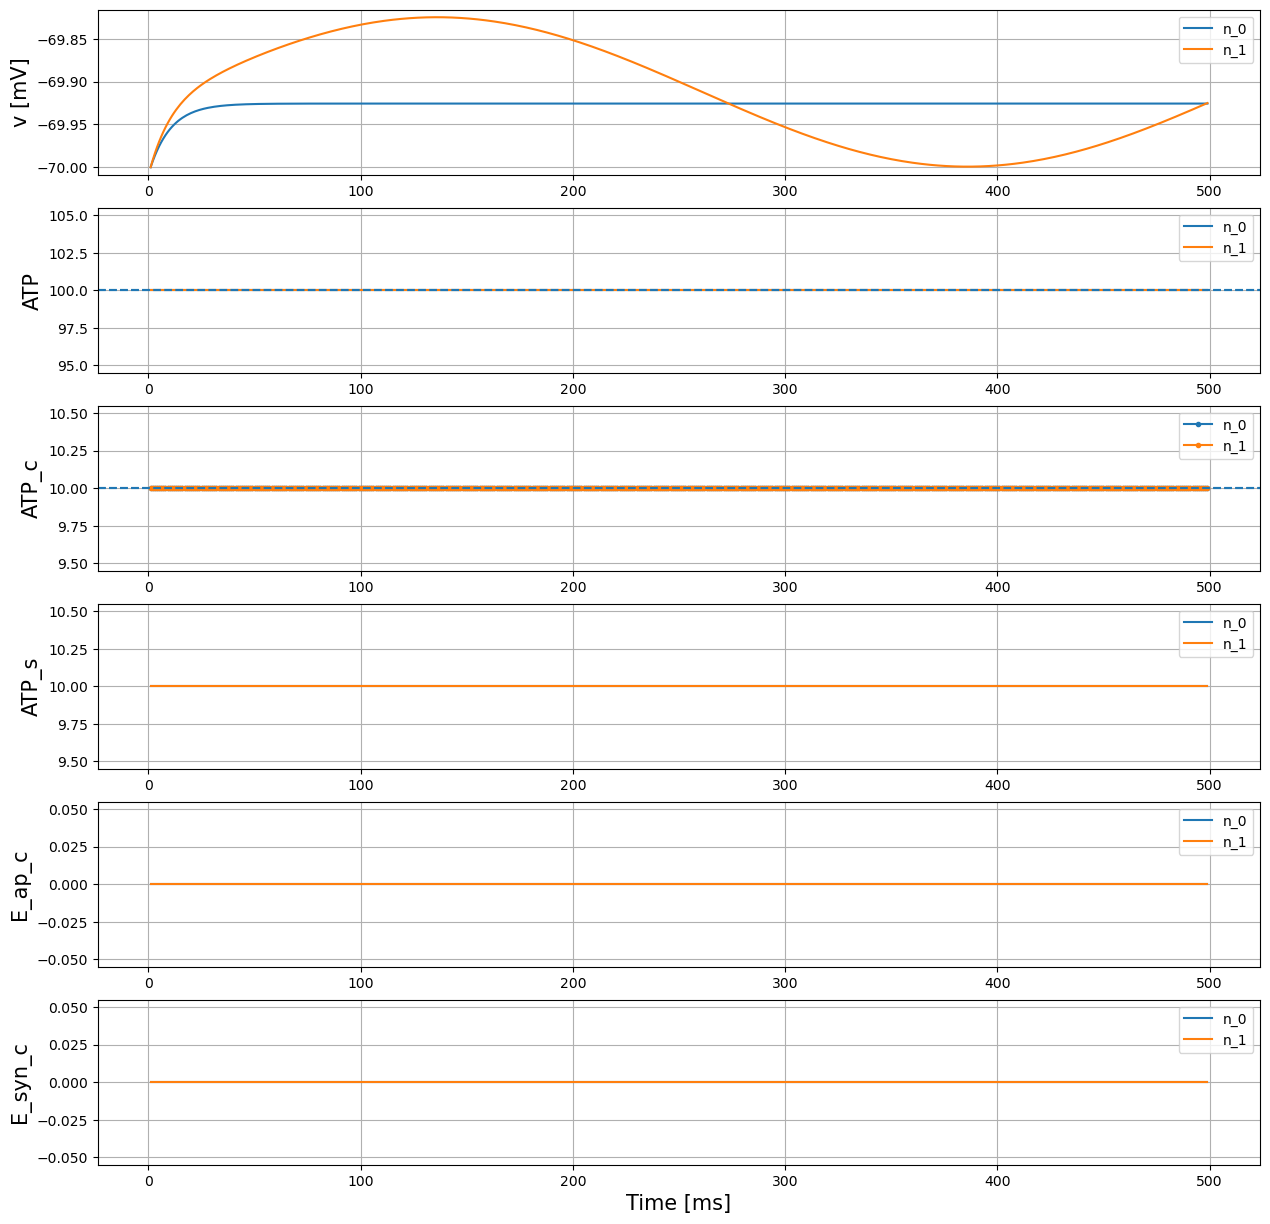

In [12]:
nest.set_verbosity("M_WARNING")
nest.ResetKernel()

# resolution
nest.resolution = 0.1
resolution = nest.GetKernelStatus()["resolution"]
print(f"resolution time: {resolution}") 

#neuron_model_name = neuron_model[neuron_id].split(".")[0]
print(f"Using neuron model: {neuron_model_name}")

# current generator
gen = "pg" # dc or ac or pg
print(f"Using {gen} current generator")

#param dict
parameter_dict = {"K_ATP": [1, 1]}
n = 1

# create neurons
pop1 = nest.Create(neuron_model_name, n, params=parameter_dict)
pop2 = nest.Create(neuron_model_name, n, params=parameter_dict)
voltmeter1 = nest.Create("voltmeter")
voltmeter2 = nest.Create("voltmeter")
voltmeter = [voltmeter1, voltmeter2]

# create connections
syn_dict = {
    "synapse_model": "stdp_synapse", 
    #"synapse_model": synapse_model_name, 
    "weight": 3000,
    "alpha": 1
            }
    
#syn_spec = ={"weight":2350.0}
nest.Connect(pop1, pop2,
             "one_to_one",
             syn_spec=syn_dict)

voltmeter[0].set({"record_from": ["V_m", "ATP", "ATP_c", "ATP_s", "E_ap_tr", "E_ap_c", "E_syn_c"]}) #, "E_ap_der", "E_ap_tr2"]})
voltmeter[1].set({"record_from": ["V_m", "ATP", "ATP_c", "ATP_s", "E_ap_tr", "E_ap_c", "E_syn_c"]}) #, "E_ap_der", "E_ap_tr2"]})
nest.Connect(voltmeter1, pop1)
nest.Connect(voltmeter2, pop2)

"""
if gen == "dc":
    cgs = nest.Create('dc_generator')
    cgs.set({"amplitude": 1.80})
elif gen == "ac":
    cgs = nest.Create('ac_generator')
    cgs.set({"amplitude": 2.2})
    cgs.set({"offset": 2.2})
    cgs.set({"frequency": 4})
elif gen == "pg":
    cgs = nest.Create('poisson_generator')
    cgs.set({"start": 50.0, "stop": 400.0, "rate": 230000})
    cgs2 = nest.Create('poisson_generator')
    cgs2.set({"start": 20.0, "stop": 350.0, "rate": 200000})
"""
dcs = nest.Create('dc_generator')
dcs.set({"amplitude": 1.86})   

acs = nest.Create('ac_generator')
acs.set({"amplitude": 2.2})
acs.set({"offset": 2.2})
acs.set({"frequency": 2})
  
nest.Connect(dcs, pop1)
nest.Connect(acs, pop2)


sr = nest.Create("spike_recorder")
nest.Connect(pop1, sr)
nest.Connect(pop2, sr)

nest.Simulate(1*500.)

# precision
#error = nest.GetStatus(pop1, "gsl_error_tol")
#print(f"absolute error of integration: {error}")


# new arrays for reshaped arrays
ts = []
Vms = []
atp = []
atp_h = []
atp_c = []
atp_s = []
e_ap_c = []
e_syn_c = []
st = []

fontsize = 15
fig, ax = plt.subplots(nrows=6, figsize=(15,15))

for idx in range(2):
    # reshape arrays
    print(f"idx: {idx}")
    ts.append(voltmeter[idx].get("events")["times"])
    Vms.append(voltmeter[idx].get("events")["V_m"])
    atp.append(voltmeter[idx].get("events")["ATP"])
    atp_h.append(pop1.get("ATP_h"))
    atp_c.append(voltmeter[idx].get("events")["ATP_c"])
    atp_s.append(voltmeter[idx].get("events")["ATP_s"])
    e_ap_c.append(voltmeter[idx].get("events")["E_ap_c"])
    e_syn_c.append(voltmeter[idx].get("events")["E_syn_c"])
    
    # plot
    ax[0].plot(ts[idx], Vms[idx], label=f"n_{idx}")
    ax[1].plot(ts[idx], atp[idx], label=f"n_{idx}")
    ax[1].axhline(y=atp_h[idx], ls="--")
    ax[2].plot(ts[idx], atp_c[idx], marker ='.', label=f"n_{idx}")
    ax[2].axhline(y=pop1.get("ATP_basal"), ls="--")
    ax[3].plot(ts[idx], atp_s[idx], label=f"n_{idx}")
    ax[4].plot(ts[idx], e_ap_c[idx], label=f"n_{idx}")
    #ax[5].plot(voltmeter.get("events")["times"], voltmeter.get("events")["E_ap_tr2"], c="b")
    #ax[5].plot(voltmeter.get("events")["times"], voltmeter.get("events")["E_ap_der"], c="r")
    ax[5].plot(ts[idx], e_syn_c[idx], label=f"n_{idx}")
    for _ax in ax:
        _ax.grid(True)
        _ax.legend()
    ax[0].set_ylabel("v [mV]", fontsize=fontsize)
    ax[1].set_ylabel("ATP", fontsize=fontsize)
    ax[2].set_ylabel("ATP_c", fontsize=fontsize)
    ax[3].set_ylabel("ATP_s", fontsize=fontsize)
    ax[4].set_ylabel("E_ap_tr", fontsize=fontsize)
    ax[4].set_ylabel("E_ap_c", fontsize=fontsize)
    ax[5].set_ylabel("E_syn_c", fontsize=fontsize)
    ax[-1].set_xlabel("Time [ms]", fontsize=fontsize)
    
    fig.show()

# ED-STDP

In [13]:
syn_dict = {
    "synapse_model": synapse_model_name, 
    "weight": 3000,
    "alpha": 1
            }

In [14]:
neuron_model_name

'edlif_psc_exp_percent0_nestml__with_ed_stdp0_nestml'

In [15]:
nest.set_verbosity("M_WARNING")
nest.ResetKernel()

# resolution
nest.resolution = 0.1
resolution = nest.GetKernelStatus()["resolution"]
print(f"resolution time: {resolution}") 

#neuron_model_name = neuron_model[neuron_id].split(".")[0]
print(f"Using neuron model: {neuron_model_name}")

#param dict
parameter_dict = {"K_ATP": [1, 1]}
n = 1

# create neurons
pop1 = nest.Create(neuron_model_name, n, params=parameter_dict)
pop2 = nest.Create(neuron_model_name, n, params=parameter_dict)
voltmeter1 = nest.Create("voltmeter")
voltmeter2 = nest.Create("voltmeter")
voltmeter = [voltmeter1, voltmeter2]

# create connections
syn_dict = {
    #"synapse_model": "stdp_synapse", 
    "synapse_model": synapse_model_name, 
    #"weight": 3000,
    #"alpha": 1
            }
    
#syn_spec = ={"weight":2350.0}

nest.Connect(pop1, pop2,
             "one_to_one",
             syn_spec=syn_dict)


resolution time: 0.1
May 09 22:39:16 edlif_psc_exp_percent0_nestml [Warning]: 

Using neuron model: edlif_psc_exp_percent0_nestml__with_ed_stdp0_nestml
    Simulation resolution has changed. Internal state and parameters of the 
    model have been reset!

May 09 22:39:16 edlif_psc_exp_percent0_nestml__with_ed_stdp0_nestml [Warning]: 
    Simulation resolution has changed. Internal state and parameters of the 
    model have been reset!


In [19]:
voltmeter[0].set({"record_from": ["V_m", "ATP", "ATP_c", "ATP_s", "E_ap_tr", "E_ap_c", "E_syn_c"]}) #, "E_ap_der", "E_ap_tr2"]})
voltmeter[1].set({"record_from": ["V_m", "ATP", "ATP_c", "ATP_s", "E_ap_tr", "E_ap_c", "E_syn_c"]}) #, "E_ap_der", "E_ap_tr2"]})
nest.Connect(voltmeter1, pop1)
nest.Connect(voltmeter2, pop2)

idx: 0
idx: 1


/tmp/ipykernel_1815946/2165574869.py:73: UserWarning:FigureCanvasAgg is non-interactive, and thus cannot be shown


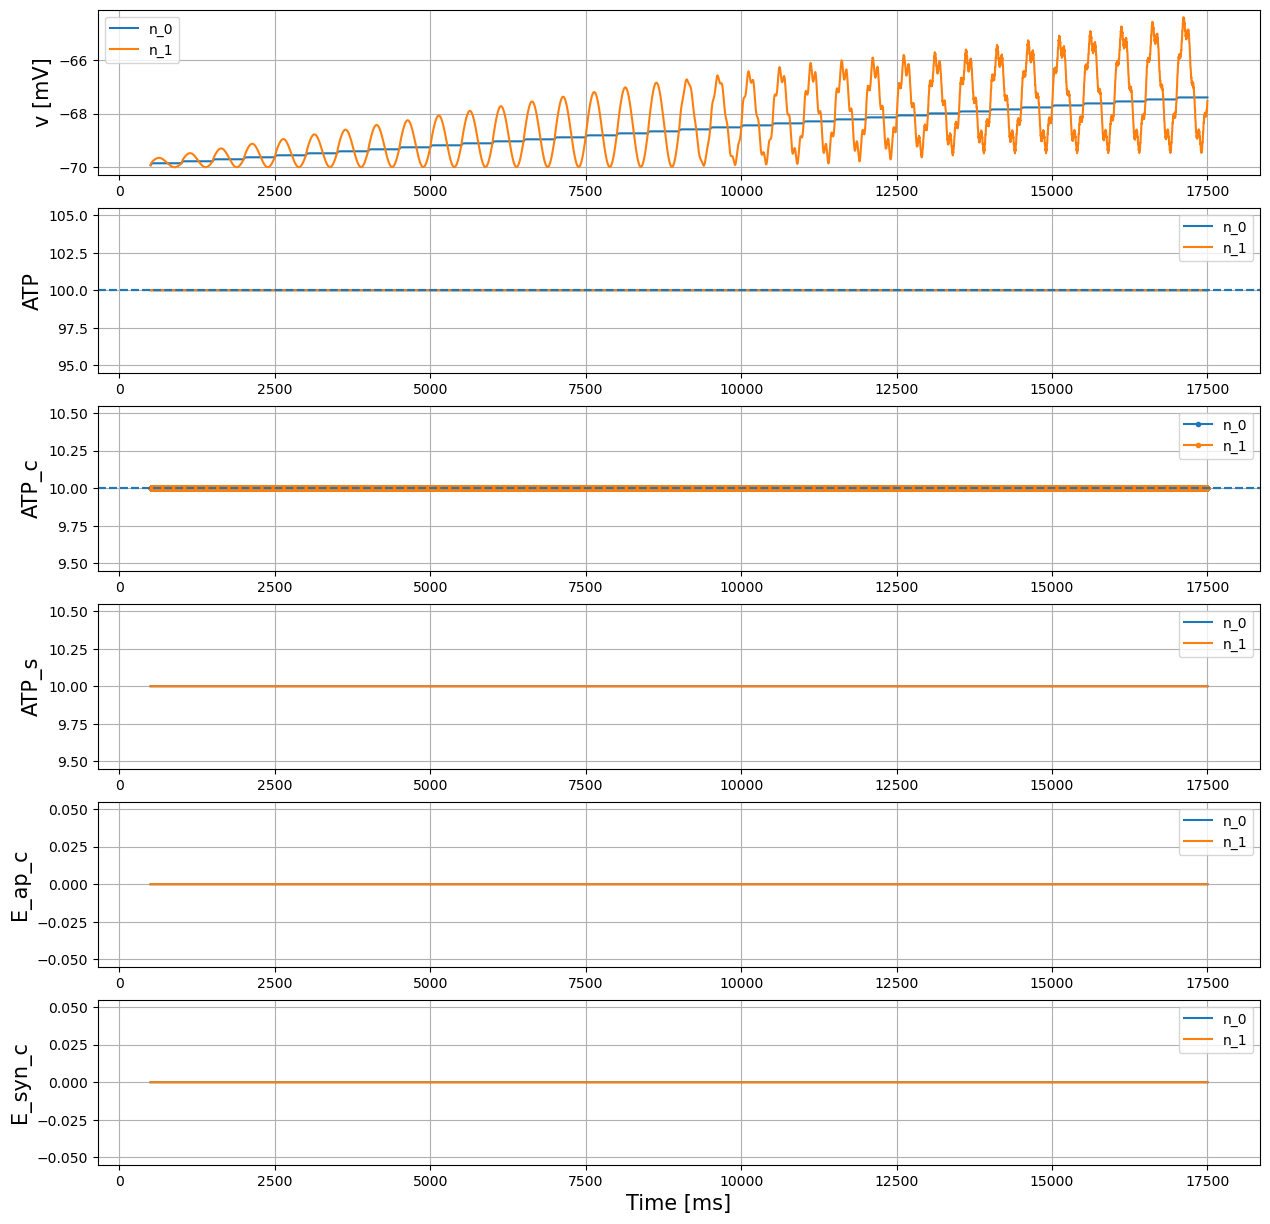

In [53]:
dcs = nest.Create('dc_generator')
dcs.set({"amplitude": 1.86})   

acs = nest.Create('ac_generator')
acs.set({"amplitude": 2.2})
acs.set({"offset": 2.2})
acs.set({"frequency": 2})
  
nest.Connect(dcs, pop1)
nest.Connect(acs, pop2)


sr = nest.Create("spike_recorder")
nest.Connect(pop1, sr)
nest.Connect(pop2, sr)

nest.Simulate(1*500.)

# precision
#error = nest.GetStatus(pop1, "gsl_error_tol")
#print(f"absolute error of integration: {error}")


# new arrays for reshaped arrays
ts = []
Vms = []
atp = []
atp_h = []
atp_c = []
atp_s = []
e_ap_c = []
e_syn_c = []
st = []

fontsize = 15
fig, ax = plt.subplots(nrows=6, figsize=(15,15))

for idx in range(2):
    # reshape arrays
    print(f"idx: {idx}")
    ts.append(voltmeter[idx].get("events")["times"])
    Vms.append(voltmeter[idx].get("events")["V_m"])
    atp.append(voltmeter[idx].get("events")["ATP"])
    atp_h.append(pop1.get("ATP_h"))
    atp_c.append(voltmeter[idx].get("events")["ATP_c"])
    atp_s.append(voltmeter[idx].get("events")["ATP_s"])
    e_ap_c.append(voltmeter[idx].get("events")["E_ap_c"])
    e_syn_c.append(voltmeter[idx].get("events")["E_syn_c"])
    
    # plot
    ax[0].plot(ts[idx], Vms[idx], label=f"n_{idx}")
    ax[1].plot(ts[idx], atp[idx], label=f"n_{idx}")
    ax[1].axhline(y=atp_h[idx], ls="--")
    ax[2].plot(ts[idx], atp_c[idx], marker ='.', label=f"n_{idx}")
    ax[2].axhline(y=pop1.get("ATP_basal"), ls="--")
    ax[3].plot(ts[idx], atp_s[idx], label=f"n_{idx}")
    ax[4].plot(ts[idx], e_ap_c[idx], label=f"n_{idx}")
    #ax[5].plot(voltmeter.get("events")["times"], voltmeter.get("events")["E_ap_tr2"], c="b")
    #ax[5].plot(voltmeter.get("events")["times"], voltmeter.get("events")["E_ap_der"], c="r")
    ax[5].plot(ts[idx], e_syn_c[idx], label=f"n_{idx}")
    for _ax in ax:
        _ax.grid(True)
        _ax.legend()
    ax[0].set_ylabel("v [mV]", fontsize=fontsize)
    ax[1].set_ylabel("ATP", fontsize=fontsize)
    ax[2].set_ylabel("ATP_c", fontsize=fontsize)
    ax[3].set_ylabel("ATP_s", fontsize=fontsize)
    ax[4].set_ylabel("E_ap_tr", fontsize=fontsize)
    ax[4].set_ylabel("E_ap_c", fontsize=fontsize)
    ax[5].set_ylabel("E_syn_c", fontsize=fontsize)
    ax[-1].set_xlabel("Time [ms]", fontsize=fontsize)
    
    fig.show()